# Training and Testing Classifiers with Watson Visual Recognition

First,  we import a bunch of things we're going to need.  You can install these with `pip`.  I recommend you create
a virtual environment. 

If you are using Anaconda,  you can do `conda create --name watson_vr python=3`

This will create a new environment named `watson_vr` which you can activate with `source activate watson_vr`
and then you can run `pip install -r requirements.txt` to get all the libraries installed.

In [1]:
from sklearn.model_selection import train_test_split

In [2]:
from watson_developer_cloud import VisualRecognitionV3

In [3]:
from zipfile import ZipFile
import os
from tempfile import TemporaryDirectory
import matplotlib.pyplot as plt
import numpy as np
import pandas
from time import sleep
import itertools

## You'll need a Visual Recognition API Key

You can get that from Bluemix after you activate the service.

In [4]:
API_KEY = os.getenv('API_KEY') or 'ENTER YOUR API KEY HERE'

## This is just some helper code

The following cell sets up some helper code I'll be using in this notebook.  

In [5]:
class PositiveClass:
    def __init__(self, class_name, tmpdir, urls):
        self.tmpdir = tmpdir
        self.class_name = class_name
        self.urls = urls
        
    def name(self):
        return self.class_name

    def path(self):
        return os.path.join(self.tmpdir.name,
                            "{0}_positive_examples.zip".format(self.name()))
        
    def zipfile(self):
        output_zipfile_name = self.path()
        if os.path.isfile(output_zipfile_name):
            return output_zipfile_name
        
        with ZipFile(output_zipfile_name, mode="w") as output_zip:
            for image in self.urls:
                with open(image, 'rb') as imagefile:
                    arc_name = os.path.basename(image)
                    output_zip.writestr(arc_name, imagefile.read())
        return output_zipfile_name

class NegativeClass(PositiveClass):
    def __init__(self, tmpdir, urls):
        super().__init__("negative", tmpdir, urls)
        
    def path(self):
        return os.path.join(self.tmpdir.name,"negative_examples.zip")
    
def desc_stats(numbers):
    return { 'std dev': np.std(numbers),
    'mean': np.mean(numbers),
     'min': np.min(numbers),
     'max': np.max(numbers)
    }

In [6]:
tempDir = TemporaryDirectory()

In [7]:
os.listdir("images")

['beagle', 'goldenretriever', 'negatives']

## The Magic Starts Here

It's not really magic.  The heavy lifting here is done by a function from [scikit-learn](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) that splist an array of objects into 
two arrays.  I just use the default, which is a `75/25` split (meaning 75% of the items are in the `train` set and 25% are in the test set).  This is all nicely randomized so your images are bucketed nicely.

For this discussion, I'm using images from the [Watson Visual Recognition Demo](https://visual-recognition-demo.mybluemix.net) and I'm going to create a custom classifier with two classes:  `golden` and `beagle` which contain images of Golden Retrievers and Beagles respectively.  I'm also going to be supplying a set of images that are not in any of those two classes (See [the docs](https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html) for real details about how this all works).  

In [8]:
#http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

base_path_gr = "./images/goldenretriever/"
train_gr, test_gr = train_test_split(os.listdir(base_path_gr))
test_gr_images = [os.path.join(base_path_gr,x) for x in test_gr]

base_path_beagle = "./images/beagle/"
train_beagle, test_beagle = train_test_split(os.listdir(base_path_beagle))
test_beagle_images = [os.path.join(base_path_beagle,x) for x in test_beagle]

base_path_negative = "./images/negatives/"
train_negative = os.listdir(base_path_negative)

gr = PositiveClass("golden", tempDir, [os.path.join(base_path_gr,x) for x in train_gr])
beagle = PositiveClass("beagle", tempDir, [os.path.join(base_path_beagle,x) for x in train_beagle])

negative = NegativeClass(tempDir, [os.path.join(base_path_negative,x) for x in train_negative])

Now we instantiate a client class and list the classifiers available just to make sure we can connect and everything is good.  

In [9]:
vr = VisualRecognitionV3(version='2017-01-31', api_key=API_KEY)
vr.list_classifiers()

{'classifiers': [{'classifier_id': 'DogBreeds_873033721',
   'name': 'Dog Breeds',
   'status': 'ready'},
  {'classifier_id': 'POC_one_2092200629',
   'name': 'POC_one',
   'status': 'failed'},
  {'classifier_id': 'InsuranceClaims_1476531008',
   'name': 'Insurance Claims',
   'status': 'failed'},
  {'classifier_id': 'InsuranceClaims_17941643',
   'name': 'Insurance Claims',
   'status': 'failed'},
  {'classifier_id': 'POC_four_1684570840',
   'name': 'POC_four',
   'status': 'ready'},
  {'classifier_id': 'POC_two_339503406', 'name': 'POC_two', 'status': 'ready'},
  {'classifier_id': 'openthedoor_63903526',
   'name': 'openthedoor',
   'status': 'ready'},
  {'classifier_id': 'DrinkCups_259744016',
   'name': 'Drink Cups',
   'status': 'ready'},
  {'classifier_id': 'A_1693693550', 'name': 'A', 'status': 'ready'},
  {'classifier_id': 'ISTest_151456679', 'name': 'IS Test', 'status': 'ready'},
  {'classifier_id': 'SatelliteImagery_464026321',
   'name': 'Satellite Imagery',
   'status': 'r

## Training

To train a classifier, we use a zipfile of the training files and submit that to the service. 

Training takes a while,  so don't be surprised and while you're waiting you can See [the docs](https://www.ibm.com/watson/developercloud/doc/visual-recognition/customizing.html).

In [10]:
grzip = open(gr.zipfile(), 'rb')
beaglezip = open(beagle.zipfile(), 'rb')
negativezip = open(negative.zipfile(), 'rb')

created_id = vr.create_classifier(golden_positive_examples=grzip,
                                  beagle_positive_examples=beaglezip,
                                  negative_examples=negativezip,
                                  name="POC_four")

Even though training takes a while, we get back the classifier ID immediately and will poll the service to find out when the training has finished.  

In [14]:
my_classifier_id = created_id["classifier_id"]

vr.get_classifier(created_id["classifier_id"])

{'classes': [{'class': 'golden'}, {'class': 'beagle'}],
 'classifier_id': 'POC_four_640205389',
 'created': '2017-05-15T18:33:30.222Z',
 'name': 'POC_four',
 'owner': '58b61352-678c-44d1-9f40-40edf4ea8d19',
 'status': 'ready'}

## Testing

Once the classifier is training, we can test our images.  Since we have a batch of test images already from splitting the data earlier, we can just feed each one of these images to the system and get the results.  This will also take some time to complete.  

This call will use both the custom classier created earlier and the default classifier that's always there.   In many applications, the tags returned can be used to infer other information about whats in the image (though that is not covered in this notebook).

In these tests I'm passing in a `threshold` value of `0.8`.  This means only classes with a score `>` `0.8` will be returned. The default threshold is `0.5` but I wanted to limit the data returned so it shows up cleaning in the datatable below. 

In [15]:
%%time
test_results = []

test_image_files = test_beagle_images

for image_file in test_image_files:
    with open(image_file,'rb') as ifile:
        result = vr.classify(images_file=ifile, classifier_ids=[my_classifier_id,'default'],threshold=0.8)
        test_results.append(result)

CPU times: user 215 ms, sys: 16.4 ms, total: 232 ms
Wall time: 37.5 s


{'custom_classes': 2, 'images': [{'classifiers': [{'classes': [{'class': 'beagle', 'score': 0.922255}], 'classifier_id': 'POC_four_640205389', 'name': 'POC_four'}, {'classes': [{'class': 'hound dog', 'score': 0.91, 'type_hierarchy': '/domestic animal/hound dog'}, {'class': 'dog', 'score': 0.974}, {'class': 'domestic animal', 'score': 0.974}, {'class': 'animal', 'score': 0.974}, {'class': 'reddish orange color', 'score': 0.886}], 'classifier_id': 'default', 'name': 'default'}], 'image': './images/beagle/Beagle_745.jpg'}], 'images_processed': 1}


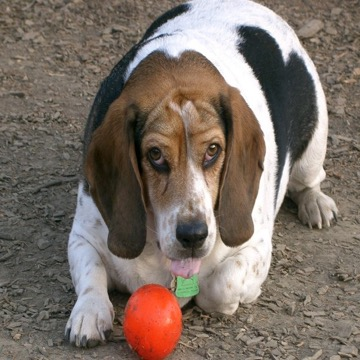

In [16]:
# this is just an example of how to classify a single image
from IPython.display import Image
with open(test_image_files[0], 'rb') as ifile:
    print(vr.classify(images_file=ifile, classifier_ids=[my_classifier_id,'default'],threshold=0.8))
Image(filename=test_image_files[0]) 

Now that we've got our results,  this code will flatten the results for visualization.  The service returns a pretty dense JSON payload,  I'm only going to look at the classes for this example.

In [17]:
class_scores = {}
# DANGER WILL ROBINSON:  the following is a set of
# actions that flatten the list of classes returned by the classifiers
scores_list = list(itertools.chain(*[m['classes'] 
                       for m 
                       in list(itertools.chain(*[z[0]['classifiers'] 
                                                 for z 
                                                 in [u['images'] 
                                                     for u 
                                                     in test_results]]))]))
for y in scores_list:
    if y['class'] in class_scores:
        class_scores[y['class']].append(y['score'])
    else:
        class_scores[y['class']]=[y['score']]

Now that we have flattened the data,  you'll see a plot of the scores and a dataframe of the score results.  It's important to remember that the `score` is not a confidence score, or a percentage.  However, we use the scores for the threshold. 

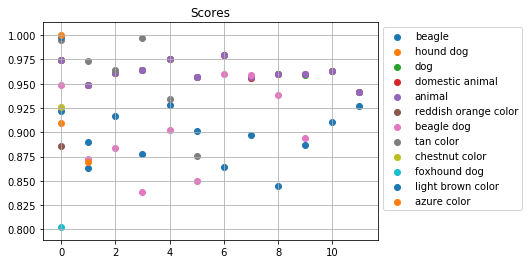

,animal,azure color,beagle,beagle dog,chestnut color,dog,domestic animal,foxhound dog,hound dog,light brown color,reddish orange color,tan color
max,0.980000,1.0000,0.928318,0.960000,0.926,0.980000,0.980000,0.802,0.91,0.9980,0.886,0.997000
mean,0.961750,0.9345,0.897216,0.904600,0.926,0.961583,0.961667,0.802,0.91,0.9305,0.886,0.956500
min,0.941000,0.8690,0.844382,0.838000,0.926,0.941000,0.941000,0.802,0.91,0.8630,0.886,0.876000
std dev,0.010449,0.0655,0.024995,0.042589,0.000,0.010508,0.010491,0.000,0.00,0.0675,0.000,0.041708


In [18]:
labels = class_scores.keys()

for l in labels:
    plt.scatter(range(0,len(class_scores[l])), class_scores[l], label=l)

plt.legend(bbox_to_anchor=(1, 1))
plt.grid(True)
plt.title("Scores")
plt.show()

pandas.DataFrame(dict([(x,desc_stats(class_scores[x])) for x in labels]))

# Retraining

Now that I've shown the scores,  I can add more images and retrain our classifier.  This is done much the same way the classifier is trainined to start with, and here I'm just using some more data and updating the classifier.  When its status is no longer `retraining` it is ready to go with that new data set learned.  

In [19]:
updated_gr = PositiveClass("golden", tempDir, [os.path.join(base_path_gr,x) for x in test_gr])

update_gr_file = open(updated_gr.zipfile(),'rb')
vr.update_classifier(classifier_id=my_classifier_id, golden_positive_examples=update_gr_file)

{'classes': [{'class': 'golden'}, {'class': 'beagle'}],
 'classifier_id': 'POC_four_640205389',
 'created': '2017-05-15T18:33:30.222Z',
 'name': 'POC_four',
 'owner': '58b61352-678c-44d1-9f40-40edf4ea8d19',
 'status': 'retraining'}